In [ ]:
!pip install pymc

In [ ]:
from google.colab import files

# Upload the dataset
uploaded = files.upload()


Saving ipl_2022_deliveries.csv.zip to ipl_2022_deliveries.csv.zip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pymc as pm
import arviz as az
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Load the dataset
zip_file_path = "ipl_2022_deliveries.csv.zip"
csv_file_name = "ipl_2022_deliveries.csv"
pdf_file_name = "pairs_trading_report.pdf" # Name of the file to remove if it exists

import zipfile
import os

# Unzip the file
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('.')
    print(f"Successfully extracted {zip_file_path}")

    # Check if the PDF file exists and remove it
    if os.path.exists(pdf_file_name):
        os.remove(pdf_file_name)
        print(f"Removed unwanted file: {pdf_file_name}")

except FileNotFoundError:
    print(f"Error: ZIP file not found at {zip_file_path}")
except zipfile.BadZipFile:
    print(f"Error: Could not read ZIP file {zip_file_path}. It might be corrupted.")
except Exception as e:
    print(f"An error occurred during unzipping or file removal: {e}")


# Now read the extracted CSV file
try:
    data = pd.read_csv(csv_file_name)
    print(f"Successfully loaded data from {csv_file_name}")

except FileNotFoundError:
    print(f"Error: CSV file not found after extraction at {csv_file_name}")
except Exception as e:
    print(f"An error occurred while reading the CSV file: {e}")


# Insert this code block right after loading the data and before creating the is_six variable
# Check if 'non-striker' column exists, and if not, handle appropriately
if 'non_striker' not in data.columns and 'non-striker' in data.columns:
    # Rename the column to match our code
    data.rename(columns={'non-striker': 'non_striker'}, inplace=True)

# Check if 'runs_of_bat' exists in the data (as per provided column names)
# If not, check for alternative spellings
if 'runs_of_bat' not in data.columns and 'runs_off_bat' in data.columns:
    # If 'runs_off_bat' exists instead, use that
    print("Using 'runs_off_bat' column instead of 'runs_of_bat'")
    data.rename(columns={'runs_off_bat': 'runs_of_bat'}, inplace=True)
# Display basic information about the dataset
# Option 2: Filter for specific teams (e.g., 8 teams)
# Replace the list with the teams you want to include
teams_to_include = ['CSK', 'MI', 'RR']
data = data[data['batting_team'].isin(teams_to_include)].copy()

print("Dataset shape:", data.shape)
print("\nColumn names:", data.columns.tolist())
print("\nFirst few rows of the data:")
display(data.head()) # Use display in Colab notebooks

Successfully extracted ipl_2022_deliveries.csv.zip
Removed unwanted file: pairs_trading_report.pdf
Successfully loaded data from ipl_2022_deliveries.csv
Dataset shape: (5517, 20)

Column names: ['match_id', 'season', 'match_no', 'date', 'venue', 'batting_team', 'bowling_team', 'innings', 'over', 'striker', 'bowler', 'runs_of_bat', 'extras', 'wide', 'legbyes', 'byes', 'noballs', 'wicket_type', 'player_dismissed', 'fielder']

First few rows of the data:


,match_id,season,match_no,date,venue,batting_team,bowling_team,innings,over,striker,bowler,runs_of_bat,extras,wide,legbyes,byes,noballs,wicket_type,player_dismissed,fielder
0,202201,2022,1,"Mar 26, 2022","Wankhede Stadium, Mumbai",CSK,KKR,1,0.1,Gaikwad,Umesh Yadav,0,1,0,0,0,1,NaN,NaN,NaN
1,202201,2022,1,"Mar 26, 2022","Wankhede Stadium, Mumbai",CSK,KKR,1,0.1,Gaikwad,Umesh Yadav,0,0,0,0,0,0,NaN,NaN,NaN
2,202201,2022,1,"Mar 26, 2022","Wankhede Stadium, Mumbai",CSK,KKR,1,0.2,Gaikwad,Umesh Yadav,0,1,1,0,0,0,NaN,NaN,NaN
3,202201,2022,1,"Mar 26, 2022","Wankhede Stadium, Mumbai",CSK,KKR,1,0.2,Gaikwad,Umesh Yadav,0,0,0,0,0,0,NaN,NaN,NaN
4,202201,2022,1,"Mar 26, 2022","Wankhede Stadium, Mumbai",CSK,KKR,1,0.3,Gaikwad,Umesh Yadav,0,0,0,0,0,0,caught,Gaikwad,Nitish Rana


In [ ]:
# Data preprocessing
# Create a binary target variable: 1 if six was hit, 0 otherwise
data['is_six'] = (data['runs_of_bat'] == 6 ).astype(int)

# Basic exploratory data analysis
print("\nSix distribution:")
print(data['is_six'].value_counts())
print(f"Six percentage: {data['is_six'].mean()*100:.2f}%")



Six distribution:
is_six
0    5177
1     340
Name: count, dtype: int64
Six percentage: 6.16%


In [ ]:
# Feature engineering
def preprocess_data(df):
    # Create a copy to avoid SettingWithCopyWarning
    processed_df = df.copy()

    # Create a ball identifier (each row represents one delivery)
    processed_df['ball_id'] = 1

    # Extract features that might affect six-hitting probability

    # 1. Batsman's six-hitting tendency
    batsman_six_rate = processed_df.groupby('striker')['is_six'].mean().reset_index()
    batsman_six_rate.columns = ['striker', 'batsman_six_rate']
    processed_df = pd.merge(processed_df, batsman_six_rate, on='striker', how='left')

    # 2. Bowler's tendency to concede sixes
    bowler_six_rate = processed_df.groupby('bowler')['is_six'].mean().reset_index()
    bowler_six_rate.columns = ['bowler', 'bowler_six_rate']
    processed_df = pd.merge(processed_df, bowler_six_rate, on='bowler', how='left')

    # 3. Venue six rate
    venue_six_rate = processed_df.groupby('venue')['is_six'].mean().reset_index()
    venue_six_rate.columns = ['venue', 'venue_six_rate']
    processed_df = pd.merge(processed_df, venue_six_rate, on='venue', how='left')

    # 4. Over information (early, middle, death overs)
    processed_df['over_phase'] = pd.cut(processed_df['over'],
                                       bins=[0, 6, 15, 20],
                                       labels=['powerplay', 'middle', 'death'],
                                       right=False) # Use right=False for consistency with 0-based indexing if needed. Bins are usually inclusive of right boundary except the last one by default, but explicit is better. Let's use [0, 6), [6, 15), [15, 20).
                                       # Note: Over 20 would fall outside. Consider adding a bin like [20, inf) if overs > 20 are possible.

    # 5. Batting team's six-hitting rate
    team_six_rate = processed_df.groupby('batting_team')['is_six'].mean().reset_index()
    team_six_rate.columns = ['batting_team', 'team_six_rate']
    processed_df = pd.merge(processed_df, team_six_rate, on='batting_team', how='left')

    # 6. Create features for current batsman's score and strike rate
    # Calculate cumulative runs and balls faced directly within the grouped dataframe
    processed_df['batsman_score'] = processed_df.groupby(['match_id', 'innings', 'striker'])['runs_of_bat'].cumsum()
    processed_df['balls_faced'] = processed_df.groupby(['match_id', 'innings', 'striker'])['ball_id'].cumsum()

    # Calculate strike rate
    # Avoid division by zero if balls_faced is 0
    # Use np.where for a cleaner calculation
    processed_df['strike_rate'] = np.where(
        processed_df['balls_faced'] > 0,
        (processed_df['batsman_score'] / processed_df['balls_faced']) * 100,
        0 # Assign 0 strike rate if no balls faced
    )

    # 7. One-hot encode categorical variables
    # Remove drop_first=True to keep all over phase columns
    processed_df = pd.get_dummies(processed_df, columns=['over_phase'])

    # Fill missing values created by merges (e.g., for players/venues not in training data if applicable)
    # This was already done outside, but doing it here ensures the processed_df returned is complete.
    # However, it's generally better to fill NaNs after splitting into train/test to avoid data leakage.
    # The original code fills NaNs AFTER calling preprocess_data, which is fine.
    # Let's keep the NaN filling outside the function as per the original code's structure.


    return processed_df



Processed data shape: (5517, 32)

Processed features:
['match_id', 'season', 'match_no', 'date', 'venue', 'batting_team', 'bowling_team', 'innings', 'over', 'striker', 'bowler', 'runs_of_bat', 'extras', 'wide', 'legbyes', 'byes', 'noballs', 'wicket_type', 'player_dismissed', 'fielder', 'is_six', 'ball_id', 'batsman_six_rate', 'bowler_six_rate', 'venue_six_rate', 'team_six_rate', 'batsman_score', 'balls_faced', 'strike_rate', 'over_phase_powerplay', 'over_phase_middle', 'over_phase_death']

Missing values in processed data:
match_id                   0
season                     0
match_no                   0
date                       0
venue                      0
batting_team               0
bowling_team               0
innings                    0
over                       0
striker                    0
bowler                     0
runs_of_bat                0
extras                     0
wide                       0
legbyes                    0
byes                       0
noball

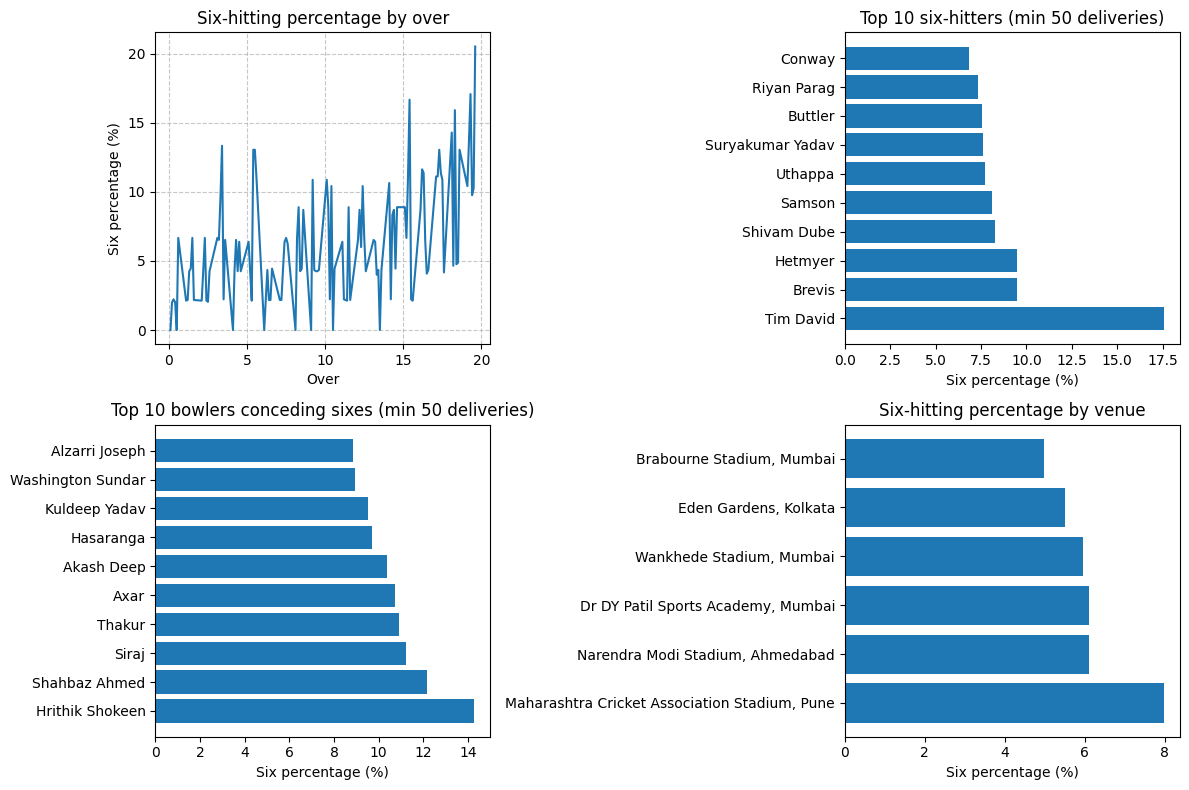

In [ ]:
# Apply preprocessing
processed_data = preprocess_data(data)

# Check the processed data
print("\nProcessed data shape:", processed_data.shape)
print("\nProcessed features:")
print(processed_data.columns.tolist()) # Print columns to verify dummy variables are created
processed_data.head()

# Display missing values
print("\nMissing values in processed data:")
print(processed_data.isnull().sum())

# Fill missing values with means or zeros
numeric_cols = ['batsman_six_rate', 'bowler_six_rate', 'venue_six_rate', 'team_six_rate',
                'batsman_score', 'strike_rate']
for col in numeric_cols:
    processed_data[col] = processed_data[col].fillna(processed_data[col].mean())

# Check again for missing values
print("\nMissing values after filling:")
print(processed_data[numeric_cols].isnull().sum())

# Visualize six-hitting rates
plt.figure(figsize=(12, 8))

# Plot six-hitting rates by over
plt.subplot(2, 2, 1)
six_by_over = data.groupby('over')['is_six'].mean()
plt.plot(six_by_over.index, six_by_over.values * 100)
plt.title('Six-hitting percentage by over')
plt.xlabel('Over')
plt.ylabel('Six percentage (%)')
plt.grid(True, linestyle='--', alpha=0.7)

# Plot top 10 batsmen with highest six rates (min 50 deliveries faced)
plt.subplot(2, 2, 2)
batsman_deliveries = data.groupby('striker').size()  # Count rows per batsman
qualified_batsmen = batsman_deliveries[batsman_deliveries >= 50].index
batsman_six_rate = data[data['striker'].isin(qualified_batsmen)].groupby('striker')['is_six'].mean().sort_values(ascending=False).head(10)
plt.barh(batsman_six_rate.index, batsman_six_rate.values * 100)
plt.title('Top 10 six-hitters (min 50 deliveries)')
plt.xlabel('Six percentage (%)')
plt.tight_layout()

# Plot top 10 bowlers conceding most sixes (min 50 deliveries bowled)
plt.subplot(2, 2, 3)
bowler_deliveries = data.groupby('bowler').size()  # Count rows per bowler
qualified_bowlers = bowler_deliveries[bowler_deliveries >= 50].index
bowler_six_rate = data[data['bowler'].isin(qualified_bowlers)].groupby('bowler')['is_six'].mean().sort_values(ascending=False).head(10)
plt.barh(bowler_six_rate.index, bowler_six_rate.values * 100)
plt.title('Top 10 bowlers conceding sixes (min 50 deliveries)')
plt.xlabel('Six percentage (%)')

# Plot six-hitting rates by venue
plt.subplot(2, 2, 4)
venue_deliveries = data.groupby('venue').size()  # Count rows per venue
qualified_venues = venue_deliveries[venue_deliveries >= 100].index
venue_six_rate = data[data['venue'].isin(qualified_venues)].groupby('venue')['is_six'].mean().sort_values(ascending=False)
plt.barh(venue_six_rate.index, venue_six_rate.values * 100)
plt.title('Six-hitting percentage by venue')
plt.xlabel('Six percentage (%)')

plt.tight_layout()
plt.savefig('six_hitting_analysis.png')
plt.show()



Training Bayesian model...


Output()

           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    -3.241  0.085  -3.394   -3.077      0.002    0.002    1258.0   
betas[0]  0.166  0.061   0.041    0.274      0.002    0.001    1430.0   
betas[1]  0.522  0.070   0.396    0.655      0.002    0.001    1400.0   
betas[2]  0.180  0.064   0.057    0.293      0.002    0.001    1718.0   
betas[3] -0.020  0.067  -0.156    0.099      0.002    0.001    1254.0   
betas[4]  0.798  0.064   0.670    0.909      0.002    0.001    1103.0   
betas[5]  0.100  6.201 -10.988   12.088      0.257    0.178     586.0   
betas[6]  0.066  5.768 -10.295   11.115      0.239    0.165     586.0   
betas[7]  0.326  5.322  -8.740   11.107      0.221    0.152     586.0   

          ess_tail  r_hat  
alpha       1222.0    1.0  
betas[0]     982.0    1.0  
betas[1]    1347.0    1.0  
betas[2]    1550.0    1.0  
betas[3]    1215.0    1.0  
betas[4]    1132.0    1.0  
betas[5]     721.0    1.0  
betas[6]     733.0    1.0  
betas[7]     726.

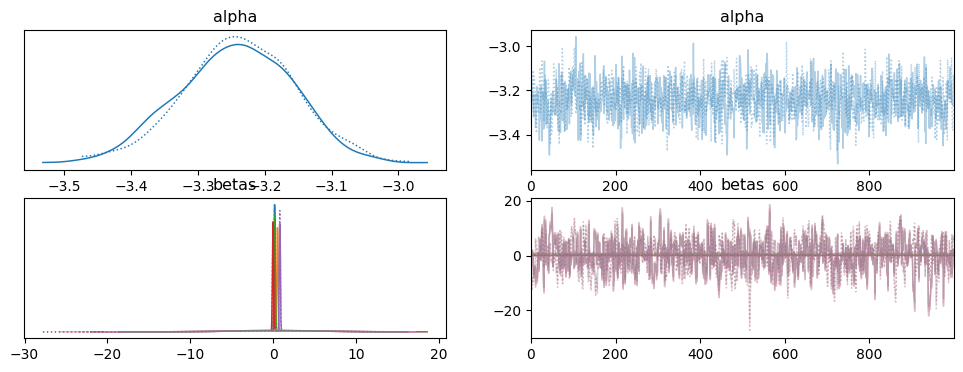

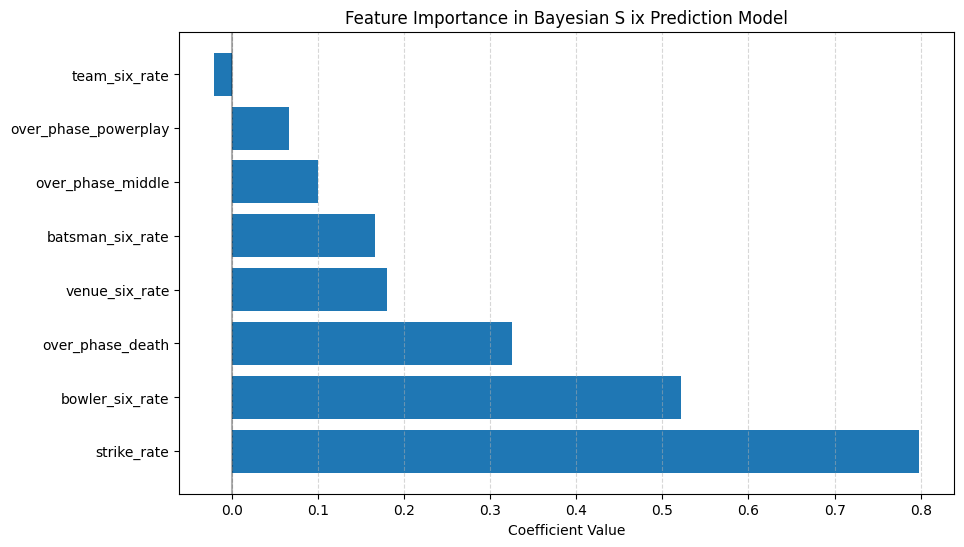

In [ ]:
# Select relevant features for our Bayesian model
# Update features list to include all over phase dummy variables
features = ['batsman_six_rate', 'bowler_six_rate', 'venue_six_rate', 'team_six_rate',
            'strike_rate', 'over_phase_middle', 'over_phase_powerplay', 'over_phase_death'] # Added 'over_phase_death'

# Split the data into training and testing sets
X = processed_data[features]
y = processed_data['is_six']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the numeric features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nTraining Bayesian model...")

# Build a Bayesian Logistic Regression Model using PyMC
with pm.Model() as logistic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    # Shape should match the number of features
    betas = pm.Normal('betas', mu=0, sigma=10, shape=len(features))

    # Expected value of outcome
    mu = alpha + pm.math.dot(X_train_scaled, betas)

    # Likelihood (sampling distribution) of observations
    y_obs = pm.Bernoulli('y_obs', logit_p=mu, observed=y_train.values)

    # Sample from the posterior
    idata = pm.sample(1000, tune=1000, cores=1, return_inferencedata=True)

# Display inference data summary
print(az.summary(idata))

# Plot the trace
az.plot_trace(idata)
plt.savefig('bayesian_model_trace.png')
plt.show()

# Extract feature importance
# Skip alpha (intercept) - make sure the indexing is correct
# The summary output might vary slightly, so inspect it if needed
# If alpha is the first parameter, feature betas will be from index 1 onwards
feature_importance = az.summary(idata)['mean'].values[1:]
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})
feature_importance_df['Abs_Importance'] = np.abs(feature_importance_df['Importance'])
feature_importance_df = feature_importance_df.sort_values('Abs_Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Bayesian S ix Prediction Model')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.savefig('feature_importance.png')
plt.show()


Model Evaluation:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1038
           1       0.44      0.06      0.11        66

    accuracy                           0.94      1104
   macro avg       0.69      0.53      0.54      1104
weighted avg       0.91      0.94      0.92      1104



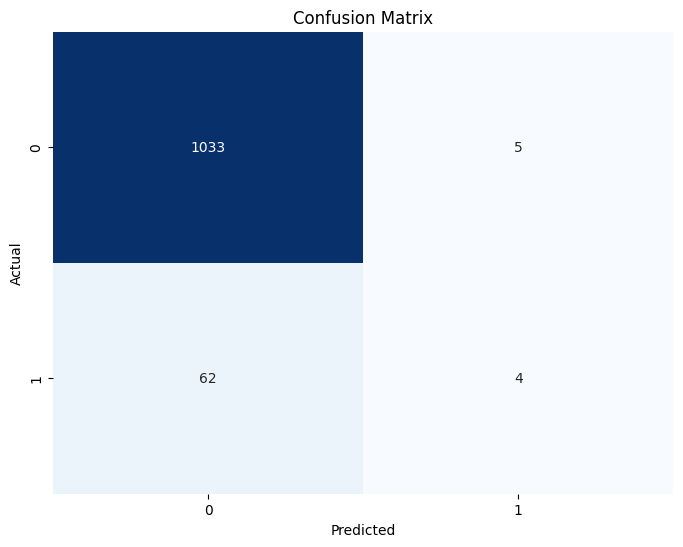

In [ ]:
# Make predictions on the test set
preds = []
with logistic_model:
    # Get samples from the posterior predictive distribution
    alpha_post = idata.posterior['alpha'].mean().item()
    betas_post = idata.posterior['betas'].mean(dim=["chain", "draw"]).values

    # Calculate predicted probabilities
    logits = alpha_post + np.dot(X_test_scaled, betas_post)
    probs = 1 / (1 + np.exp(-logits))
    preds = (probs > 0.5).astype(int)

# Evaluate the model
print("\nModel Evaluation:")
print(classification_report(y_test, preds))

# Confusion Matrix
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()


In [ ]:
# Create a function to predict six probability for new data
def predict_six_probability(batsman, bowler, venue, batting_team, strike_rate, over_phase):
    """
    Predict the probability of a six being hit on the next ball

    Parameters:
    -----------
    batsman: str
        Name of the batsman
    bowler: str
        Name of the bowler
    venue: str
        Name of the venue
    batting_team: str
        Name of the batting team
    strike_rate: float
        Current strike rate of the batsman
    over_phase: str
        'powerplay', 'middle', or 'death'

    Returns:
    --------
    float: Probability of a six being hit
    """
    # Get six rates from the data
    try:
        batsman_six_rate = processed_data[processed_data['striker'] == batsman]['batsman_six_rate'].values[0]
    except:
        batsman_six_rate = processed_data['batsman_six_rate'].mean()

    try:
        bowler_six_rate = processed_data[processed_data['bowler'] == bowler]['bowler_six_rate'].values[0]
    except:
        bowler_six_rate = processed_data['bowler_six_rate'].mean()

    try:
        venue_six_rate = processed_data[processed_data['venue'] == venue]['venue_six_rate'].values[0]
    except:
        venue_six_rate = processed_data['venue_six_rate'].mean()

    try:
        team_six_rate = processed_data[processed_data['batting_team'] == batting_team]['team_six_rate'].values[0]
    except:
        team_six_rate = processed_data['team_six_rate'].mean()

    # Create feature array, ensuring all 8 features from the training data are included
    over_phase_middle = 1 if over_phase == 'middle' else 0
    over_phase_powerplay = 1 if over_phase == 'powerplay' else 0
    over_phase_death = 1 if over_phase == 'death' else 0 # Added 'over_phase_death'

    features_new = np.array([
        batsman_six_rate,
        bowler_six_rate,
        venue_six_rate,
        team_six_rate,
        strike_rate,
        over_phase_middle,
        over_phase_powerplay,
        over_phase_death # Added 'over_phase_death' here
    ]).reshape(1, -1)

    # Scale the features
    features_new_scaled = scaler.transform(features_new)

    # Make prediction
    alpha_post = idata.posterior['alpha'].mean().item()
    betas_post = idata.posterior['betas'].mean(dim=["chain", "draw"]).values

    logit = alpha_post + np.dot(features_new_scaled, betas_post)
    probability = 1 / (1 + np.exp(-logit))[0]

    return probability

In [ ]:
# Example usage
batsman = 'Buttler'  # Replace with actual batsman from your data
bowler = 'Umesh Yadav'     # Replace with actual bowler from your data
venue = 'Eden Gardens, Kolkata'    # Replace with actual venue from your data
batting_team = 'RR' # Replace with actual team from your data
strike_rate = 150.0
over_phase = 'powerplay'

six_prob = predict_six_probability(batsman, bowler, venue, batting_team, strike_rate, over_phase)
print(f"\nProbability of {batsman} hitting a six against {bowler} at {venue} = {six_prob:.2%}")



Probability of Buttler hitting a six against Umesh Yadav at Eden Gardens, Kolkata = 3.74%


In [30]:
# Create an interactive prediction function
def interactive_prediction():
    """
    Interactive function to predict six probability
    """
    print("\n--- Six Prediction Tool ---")

    # Get top batsmen and bowlers for suggestions
    top_batsmen = data['striker'].value_counts().head(20).index.tolist()
    top_bowlers = data['bowler'].value_counts().head(20).index.tolist()
    venues = data['venue'].unique().tolist()
    teams = data['batting_team'].unique().tolist()

    print(f"\nTop batsmen in dataset: {', '.join(top_batsmen[:5])}...")
    batsman = input("Enter batsman name: ")

    print(f"\nTop bowlers in dataset: {', '.join(top_bowlers[:5])}...")
    bowler = input("Enter bowler name: ")

    print(f"\nVenues in dataset: {', '.join(venues[:5])}...")
    venue = input("Enter venue: ")

    print(f"\nTeams in dataset: {', '.join(teams)}")
    batting_team = input("Enter batting team: ")

    strike_rate = float(input("\nEnter batsman's current strike rate: "))

    print("\nOver phase options: powerplay (1-6), middle (7-15), death (16-20)")
    over_phase = input("Enter over phase: ")

    six_prob = predict_six_probability(batsman, bowler, venue, batting_team, strike_rate, over_phase)
    print(f"\nProbability of {batsman} hitting a six against {bowler} at {venue} = {six_prob:.2%}")

    return six_prob

# Run the interactive prediction tool
interactive_prediction()

# Save the model and data for later use
import pickle

# Save the processed data
processed_data.to_csv('processed_ipl_data.csv', index=False)

# Save the Bayesian model inference data
with open('bayesian_six_model.pkl', 'wb') as f:
    pickle.dump({
        'idata': idata,
        'features': features,
        'scaler': scaler
    }, f)

print("\nModel and processed data saved successfully!")



--- Six Prediction Tool ---

Top batsmen in dataset: Buttler, Ishan Kishan, Samson, Padikkal, Tilak Varma...
Enter batsman name: Tim David

Top bowlers in dataset: Shami, Rashid Khan, Hasaranga, Siraj, Narine...
Enter bowler name: Siraj

Venues in dataset: Wankhede Stadium, Mumbai, Brabourne Stadium, Mumbai, Maharashtra Cricket Association Stadium, Pune, Dr DY Patil Sports Academy, Mumbai, Eden Gardens, Kolkata...
Enter venue: Wankhede Stadium, Mumbai

Teams in dataset: CSK, MI, RR
Enter batting team: MI

Enter batsman's current strike rate: 170

Over phase options: powerplay (1-6), middle (7-15), death (16-20)
Enter over phase: death

Probability of Tim David hitting a six against Siraj at Wankhede Stadium, Mumbai = 31.11%

Model and processed data saved successfully!
